In [ ]:
# 1. Import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving BitcoinHistoricalData.csv to BitcoinHistoricalData (1).csv


In [ ]:
# 2. Load data
data = pd.read_csv('BitcoinHistoricalData.csv')
data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"Aug 02, 2020","11,105.8","11,802.6","12,061.1","10,730.7",698.62K,-5.91%
1,"Aug 01, 2020","11,803.1","11,333.2","11,847.7","11,226.1",611.47K,4.14%
2,"Jul 31, 2020","11,333.4","11,096.5","11,434.8","10,964.6",530.95K,2.14%
3,"Jul 30, 2020","11,096.2","11,105.8","11,164.4","10,861.6",501.14K,-0.09%
4,"Jul 29, 2020","11,105.9","10,908.4","11,336.5","10,771.8",576.83K,1.81%


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3669 entries, 0 to 3668
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      3669 non-null   object
 1   Price     3669 non-null   object
 2   Open      3669 non-null   object
 3   High      3669 non-null   object
 4   Low       3669 non-null   object
 5   Vol.      3669 non-null   object
 6   Change %  3669 non-null   object
dtypes: object(7)
memory usage: 200.8+ KB


In [ ]:
# 3. Data Preprocessing
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')

def convert_vol(val):
    if pd.isna(val) or val == '-':
        return 0.0
    val = str(val)
    if 'K' in val:
        return float(val.replace('K', '').replace(',', '')) * 1_000
    elif 'M' in val:
        return float(val.replace('M', '').replace(',', '')) * 1_000_000
    else:
        return float(val.replace(',', ''))

def clean_numeric(val):
    if pd.isna(val) or val == '-':
        return 0.0
    return float(str(val).replace(',', ''))

data['Vol.'] = data['Vol.'].apply(convert_vol)
data['Open'] = data['Open'].apply(clean_numeric)
data['High'] = data['High'].apply(clean_numeric)
data['Low'] = data['Low'].apply(clean_numeric)
data['Price'] = data['Price'].apply(clean_numeric)

# Xử lý Change %: ép kiểu sang string trước khi replace và chuyển đổi
data['Change %'] = (
    data['Change %']
    .astype(str)
    .str.replace('%', '', regex=False)
    .astype(float) / 100
)


In [ ]:
# 4. Select features and scale
features = ['Open', 'High', 'Low', 'Vol.', 'Change %']
target = 'Price'

scaler_all = MinMaxScaler()
scaled_all = scaler_all.fit_transform(data[features + [target]])

scaler_price = MinMaxScaler()
scaled_price = scaler_price.fit_transform(data[[target]])

In [ ]:
# 5. Create sequences for LSTM
def create_sequences(dataset, look_back=30):
    X, y = [], []
    for i in range(len(dataset) - look_back - 1):
        X.append(dataset[i:(i + look_back), :-1])
        y.append(dataset[i + look_back, -1])
    return np.array(X), np.array(y)

look_back = 30
X, y = create_sequences(scaled_all, look_back)

In [ ]:
# 6. Train-test split (80% train - 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
# 7. Build LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [ ]:
# 8. Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0055 - val_loss: 0.0015
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 6.9922e-04 - val_loss: 0.0029
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 8.0306e-04 - val_loss: 0.0021
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 4.7643e-04 - val_loss: 6.9247e-04
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 4.7762e-04 - val_loss: 9.2806e-04
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 3.2129e-04 - val_loss: 6.3708e-04
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 3.4903e-04 - val_loss: 6.7132e-04
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 3.0539e-04 - val_loss: 6.5617e-04
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 3.8933e-04 - val_loss: 5.6095e-04
Epoch 10/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2.8748e-04 - val_loss: 6.5709e-04
Epoch 11/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2.8396e-04 - val_loss: 6.

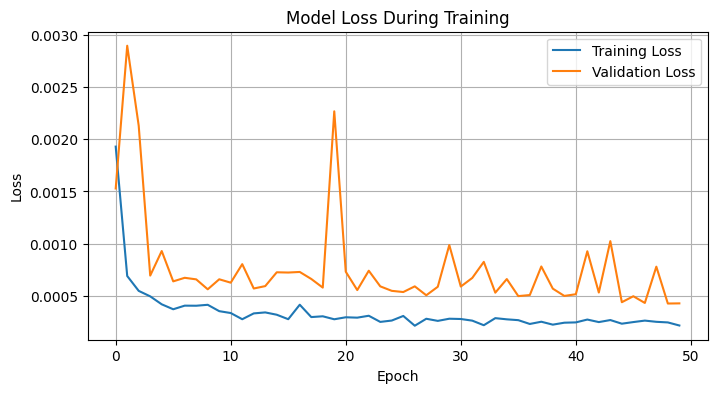

In [ ]:
# 9. Plot loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3669 entries, 3668 to 0
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      3669 non-null   datetime64[ns]
 1   Price     3669 non-null   float64       
 2   Open      3669 non-null   float64       
 3   High      3669 non-null   float64       
 4   Low       3669 non-null   float64       
 5   Vol.      3669 non-null   float64       
 6   Change %  3669 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 229.3 KB


In [ ]:
import pandas as pd
import plotly.graph_objects as go


# 2. Đảm bảo cột 'Date' ở dạng datetime
data['Date'] = pd.to_datetime(data['Date'])

# 3. Tạo cột 'Month' ở định dạng 'YYYY-MM'
data['Month'] = data['Date'].dt.to_period('M').astype(str)

# 4. Nếu các cột đã là float, không cần chuyển đổi thêm
# Nếu bạn cần phòng lỗi thì có thể thêm đoạn kiểm tra kiểu dữ liệu:
for col in ['Open', 'High', 'Low', 'Price']:
    if data[col].dtype == 'object':
        data[col] = data[col].str.replace(',', '').astype(float)

# 5. Nhóm dữ liệu theo tháng: lấy Open đầu tháng, Close cuối tháng, max High và min Low
month_data = data.groupby('Month').agg({
    'Open': 'first',
    'Price': 'last',   # Giá đóng cửa là cuối tháng
    'High': 'max',
    'Low': 'min'
}).reset_index()

# 6. Biểu đồ High và Low theo tháng
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=month_data['Month'], y=month_data['High'], mode='lines+markers', name='High Price'))
fig1.add_trace(go.Scatter(x=month_data['Month'], y=month_data['Low'], mode='lines+markers', name='Low Price'))
fig1.update_layout(title='Monthwise High and Low Bitcoin Price', xaxis_title='Month', yaxis_title='Price (USD)')
fig1.show()

# 7. Biểu đồ Open vs Close (Price) theo tháng
fig2 = go.Figure()
fig2.add_trace(go.Bar(x=month_data['Month'], y=month_data['Open'], name='Open Price'))
fig2.add_trace(go.Bar(x=month_data['Month'], y=month_data['Price'], name='Close Price'))
fig2.update_layout(title='Monthwise Open vs Close Bitcoin Price', barmode='group', xaxis_title='Month', yaxis_title='Price (USD)')
fig2.show()

# 8. Biểu đồ Candlestick tổng quan theo tháng
fig3 = go.Figure()
fig3.add_trace(go.Candlestick(
    x=month_data['Month'],
    open=month_data['Open'],
    high=month_data['High'],
    low=month_data['Low'],
    close=month_data['Price']
))
fig3.update_layout(title='Bitcoin Monthly Candlestick Chart', xaxis_title='Month', yaxis_title='Price (USD)')
fig3.show()


- Biểu đồ High và Low theo tháng:

Giúp bạn nhận diện biên độ dao động giá của Bitcoin theo từng tháng.

Nếu thấy biên độ (High - Low) ngày càng hẹp → giá có thể đang tích lũy.

Nếu biên độ tăng → thị trường có thể đang biến động mạnh (bắt đầu xu hướng mới).

- Biểu đồ Open vs Close:

Nếu giá đóng > giá mở nhiều tháng liên tiếp, thị trường có xu hướng tăng giá.

Ngược lại, nếu giá đóng < giá mở, có thể đang giảm giá.

- Candlestick Chart:

Giúp bạn nhìn rõ mô hình nến tháng (ví dụ: Doji, Hammer, Engulfing…).

Một số mô hình nến có thể gợi ý điểm đảo chiều hoặc tiếp tục xu hướng.

In [ ]:
# 10. Evaluate accuracy
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f'Train MSE: {mse_train:.6f}, Train R2: {r2_train:.4f}')
print(f'Test MSE: {mse_test:.6f}, Test R2: {r2_test:.4f}')

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Train MSE: 0.000126, Train R2: 0.9944
Test MSE: 0.000426, Test R2: 0.9702


In [ ]:
# 12. Forecast next 30 days trong tập dữ liệu đầu năm 2021
pred_input = scaled_all[-look_back:, :-1]
pred_input = pred_input.reshape(1, look_back, len(features))
predictions = []

for _ in range(30):
    next_price = model.predict(pred_input)[0][0]
    predictions.append(next_price)

    # Tạo row mới từ dự đoán
    last_features = pred_input[0, -1, :].copy()
    # Giả lập Open/High/Low bằng giá dự đoán
    last_features[0] = next_price  # Open
    last_features[1] = next_price  # High
    last_features[2] = next_price  # Low

    # Dịch dữ liệu và thêm row mới
    new_input = np.vstack([pred_input[0, 1:, :], last_features])
    pred_input = new_input.reshape(1, look_back, len(features))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━

In [ ]:
# 13. Inverse scale predictions
predictions_real = scaler_price.inverse_transform(np.array(predictions).reshape(-1,1)).flatten()


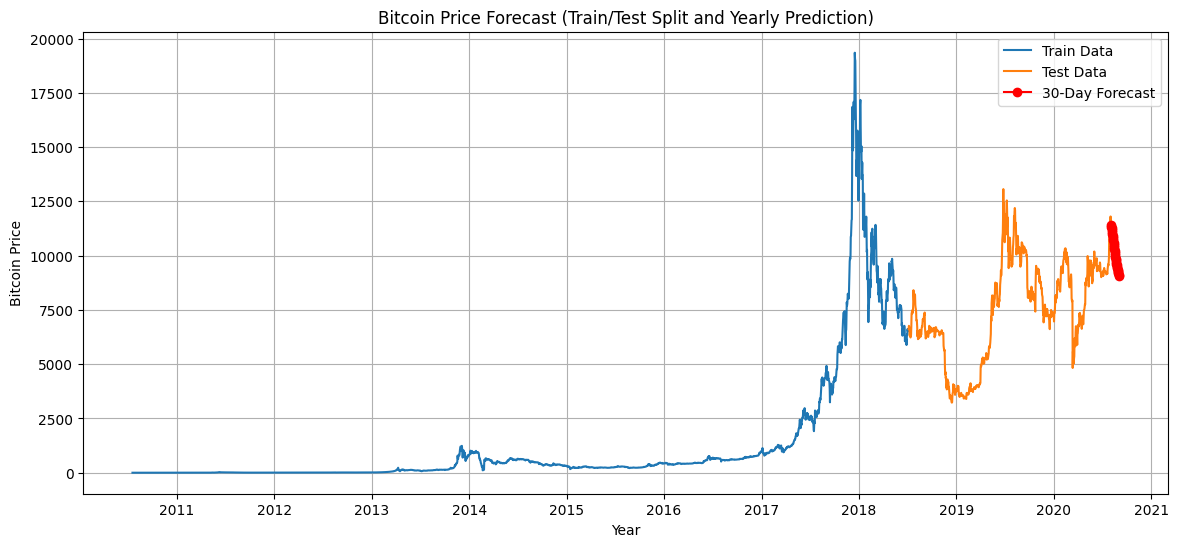

In [ ]:
# 14. Plot forecast results
import matplotlib.pyplot as plt
import matplotlib.dates as mdates  # Thêm dòng này
dates_forecast = pd.date_range(start=data['Date'].iloc[-1] + pd.Timedelta(days=1), periods=30)

plt.figure(figsize=(14,6))
plt.plot(data['Date'][:train_size], data['Price'][:train_size], label='Train Data')
plt.plot(data['Date'][train_size:], data['Price'][train_size:], label='Test Data')
plt.plot(dates_forecast, predictions_real, color='red', marker='o', label='30-Day Forecast')

# Cấu hình trục x hiển thị theo năm
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Định vị các năm trên trục x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Chỉ hiển thị số năm (2022, 2023, ...)

plt.xlabel('Year')  # Đổi nhãn trục x thành "Year"
plt.ylabel('Bitcoin Price')
plt.title('Bitcoin Price Forecast (Train/Test Split and Yearly Prediction)')
plt.legend()
plt.grid()
plt.show()


https://finance.yahoo.com/quote/%5EN225/history/?period1=1746348126&period2=1610150400

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %'], dtype='object')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning:

The model does not have any trainable weights.



0 [D loss: 0.7144635915756226 | D accuracy: 0.203125] [G loss: 0.7119035720825195]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━

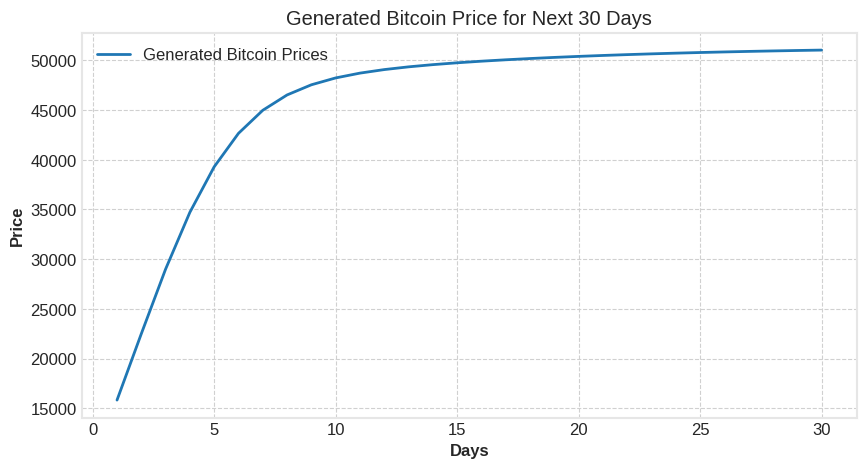

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import Adam

# 1. Load data
data = pd.read_csv('BitcoinHistoricalData.csv')
print(data.columns)  # In các tên cột để kiểm tra

# 2. Hàm chuyển đổi các giá trị với 'K', 'M' thành số thực
def convert_to_float(value):
    if isinstance(value, str):
        value = value.replace(',', '')  # Loại bỏ dấu phẩy
        if value == '-':  # Nếu giá trị là dấu '-'
            return np.nan  # Trả về NaN thay vì '-'
        if 'K' in value:
            return float(value.replace('K', '')) * 1e3  # 'K' = 1000
        elif 'M' in value:
            return float(value.replace('M', '')) * 1e6  # 'M' = 1000000
        elif 'B' in value:
            return float(value.replace('B', '')) * 1e9  # 'B' = 1000000000
    try:
        return float(value)  # Nếu không có ký tự đặc biệt, chuyển trực tiếp thành float
    except ValueError:
        return np.nan  # Nếu không thể chuyển, trả về NaN

# 3. Chuyển đổi các cột có giá trị chuỗi có 'K', 'M', 'B' thành float
columns_to_convert = ['Open', 'High', 'Low', 'Vol.', 'Change %', 'Price']

for col in columns_to_convert:
    data[col] = data[col].apply(convert_to_float)

# 4. Xử lý các giá trị NaN (Thay NaN bằng 0 hoặc giá trị trung bình)
data = data.fillna(0)  # Bạn có thể thay thế NaN bằng 0 hoặc giá trị trung bình của cột

# 5. Chọn các cột cần thiết
data = data[['Open', 'High', 'Low', 'Vol.', 'Change %', 'Price']]

# 6. Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(data)

# 7. Tạo dữ liệu chuỗi thời gian
def create_sequences(data, seq_len):
    X = []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
    return np.array(X)

seq_len = 30  # Độ dài chuỗi thời gian
data_seq = create_sequences(data_scaled, seq_len)

# 8. Tạo mô hình Generator và Discriminator

# Xác định các tham số
latent_dim = 100
n_features = data_seq.shape[2]  # Số đặc trưng (features) trong mỗi bước thời gian

# Hàm tạo Generator
def build_generator(latent_dim, seq_len, n_features):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=latent_dim))
    model.add(RepeatVector(seq_len))  # Lặp lại đầu vào thành chuỗi thời gian
    model.add(LSTM(128, return_sequences=True))
    model.add(TimeDistributed(Dense(n_features)))  # Trả về chuỗi thời gian với số lượng features
    return model

# Hàm tạo Discriminator
def build_discriminator(seq_len, n_features):
    model = Sequential()
    model.add(LSTM(128, input_shape=(seq_len, n_features)))
    model.add(Dense(1, activation='sigmoid'))  # Phân biệt thật/giả
    return model

# Hàm xây dựng mô hình GAN
def build_gan(generator, discriminator):
    discriminator.trainable = False  # Không train discriminator khi train GAN
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

generator = build_generator(latent_dim, seq_len, n_features)
discriminator = build_discriminator(seq_len, n_features)
gan = build_gan(generator, discriminator)

# 9. Compile mô hình
discriminator.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])
gan.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')

# 10. Huấn luyện mô hình GAN
def train_gan(epochs, batch_size, data):
    half_batch = batch_size // 2
    for epoch in range(epochs):
        # Chọn random dữ liệu thực từ dataset
        idx = np.random.randint(0, data.shape[0], half_batch)
        real_data = data[idx]

        # Tạo dữ liệu giả từ generator
        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        fake_data = generator.predict(noise)

        # Huấn luyện discriminator (thực và giả)
        d_loss_real = discriminator.train_on_batch(real_data, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(fake_data, np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Huấn luyện generator (mô hình GAN)
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        if epoch % 100 == 0:
            print(f"{epoch} [D loss: {d_loss[0]} | D accuracy: {d_loss[1]}] [G loss: {g_loss}]")

    return generator

# 11. Chạy huấn luyện
epochs = 50
batch_size = 32
trained_generator = train_gan(epochs, batch_size, data_seq)

# 12. Dự đoán và vẽ kết quả
noise = np.random.normal(0, 1, (30, latent_dim))  # 30 dự đoán cho 30 ngày tiếp theo
generated_data = trained_generator.predict(noise)

# Kiểm tra kích thước của generated_data (có thể là (batch_size, seq_len, n_features))
print(f"Shape of generated_data: {generated_data.shape}")

# Làm phẳng dữ liệu 3D thành 2D (flattening)
generated_data_flat = generated_data.reshape(-1, generated_data.shape[-1])

# Chuyển đổi lại giá trị thực bằng cách sử dụng scaler.inverse_transform
generated_data_real = scaler.inverse_transform(generated_data_flat)

# Chọn cột giá trị Price (giả sử cột Price là cột cuối cùng)
generated_data_real = generated_data_real[:, -1]  # Cột cuối cùng là giá trị Price


# Vẽ kết quả với trục x từ 1 đến 30 (dự đoán cho 30 ngày tiếp theo)
plt.figure(figsize=(10, 5))

# Chỉ lấy 30 giá trị cuối cùng
plt.plot(np.arange(1, 31), generated_data_real[-30:], label='Generated Bitcoin Prices')

plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.title('Generated Bitcoin Price for Next 30 Days')
plt.show()


In [ ]:
# Chuyển đổi generated_data_real thành DataFrame
generated_data_df = pd.DataFrame(generated_data_real, columns=['Generated Price'])

# In ra 5 dòng đầu tiên của DataFrame
print(generated_data_df.shape)




(900, 1)


#Làm việc với mô hình GAN để huấn luyện và tạo ra dữ liệu dự đoán giá Bitcoin trong tương lai. Sau đó, nó dự đoán và trực quan hóa giá Bitcoin trong tương lai qua một đồ thị đường.

In [ ]:
pip install mplfinance


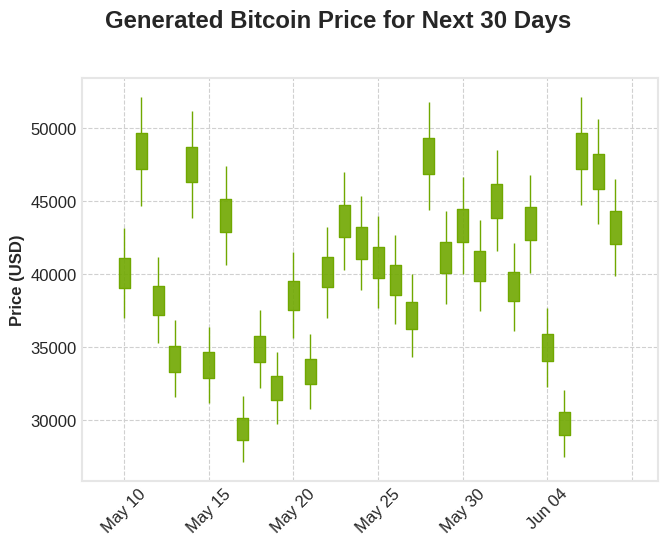

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import mplfinance as mpf

# Tạo ngày tháng cho 30 ngày tiếp theo từ ngày hiện tại
start_date = datetime.today()
dates = [start_date + timedelta(days=i) for i in range(1, 31)]  # 30 ngày tiếp theo

# Giả sử generated_data_real là dữ liệu giá trị dự đoán cho giá Bitcoin trong 30 ngày tiếp theo
# Ví dụ dữ liệu giả lập:
generated_data_real = np.random.uniform(30000, 50000, 30)  # Dự đoán giá Bitcoin trong khoảng từ 30000 đến 50000 USD

# Tạo dữ liệu giả định cho các cột Open, High, Low, Close (dữ liệu này sẽ phải thay bằng giá trị thực tế)
open_prices = generated_data_real * 0.95  # Giả sử giá mở cửa thấp hơn giá đóng cửa một chút
high_prices = generated_data_real * 1.05  # Giả sử giá cao hơn giá đóng cửa một chút
low_prices = generated_data_real * 0.90  # Giả sử giá thấp hơn giá đóng cửa một chút
close_prices = generated_data_real  # Dùng giá dự đoán làm giá đóng cửa

# Tạo DataFrame để vẽ biểu đồ nến
data_candlestick = pd.DataFrame({
    'Date': dates,
    'Open': open_prices,
    'High': high_prices,
    'Low': low_prices,
    'Close': close_prices
})

# Chuyển đổi Date thành index (chỉ định ngày tháng cho trục x)
data_candlestick.set_index('Date', inplace=True)

# Tùy chỉnh màu sắc nến và vẽ biểu đồ nến
mpf.plot(data_candlestick, type='candle', style='binance', title='Generated Bitcoin Price for Next 30 Days', ylabel='Price (USD)')




Sử dụng giá trị dự đoán giá Bitcoin (có thể từ đoạn mã 1) để tạo dữ liệu giả lập cho biểu đồ nến và vẽ biểu đồ nến để hiển thị sự biến động của giá Bitcoin trong 30 ngày tiếp theo. (Real time)